In [ ]:
import pandas as pd
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers,models
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers

import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
print('all needed modules are loaded')

all needed modules are loaded


In [ ]:
def print_in_colour(txt_msg,fore_tupple=(0,255,255),back_tupple=(100,100,100)):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    # default parameter print in cyan foreground and gray background
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m'
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

# example default print
msg='test of default colors'
print_in_colour(msg)

test of default colors



In [ ]:
print(' The version of tensorflow is ', tf.__version__)

 The version of tensorflow is  2.10.0


In [ ]:
def make_dataframes(csvpath, source_dir):
    df=pd.read_csv(csvpath)
    df['filepaths'] = df['filepaths'].apply(lambda x: os.path.join(source_dir,x))
    print('length of dataframe is ', len(df))
    groups=df.groupby('data set') # group by class
    train_df=groups.get_group('train')
    test_df=groups.get_group('test')
    valid_df=groups.get_group('valid')
    classes=sorted(train_df['labels'].unique())
    class_count=len(classes)
    sample_df=train_df.sample(n=50, replace=False)
    # calculate the average image height and with
    ht=0
    wt=0
    count=0
    for i in range(len(sample_df)):
        fpath=sample_df['filepaths'].iloc[i]
        try:
            img=cv2.imread(fpath)
            h=img.shape[0]
            w=img.shape[1]
            wt +=w
            ht +=h
            count +=1
        except:
            pass
    have=int(ht/count)
    wave=int(wt/count)
    aspect_ratio=have/wave
    print('number of classes in processed dataset= ', class_count)
    counts=list(train_df['labels'].value_counts())
    print('the maximum files in any class in train_df is ', max(counts), '  the minimum files in any class in train_df is ', min(counts))
    print('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))
    print('average image height= ', have, '  average image width= ', wave, ' aspect ratio h/w= ', aspect_ratio)
    return train_df, test_df, valid_df, classes, class_count

csvpath=r'../../Datasets/us-license-plates-image-classification/plates/plates.csv'
source_dir=r'../../Datasets/us-license-plates-image-classification/plates'
train_df, test_df, valid_df, classes, class_count=make_dataframes(csvpath, source_dir)

length of dataframe is  7860
number of classes in processed dataset=  50
the maximum files in any class in train_df is  175   the minimum files in any class in train_df is  121
train_df length:  7360   test_df length:  250   valid_df length:  250
average image height=  128   average image width=  224  aspect ratio h/w=  0.5714285714285714


In [ ]:
def trim(df, max_samples, min_samples, column):
    df = df.copy()
    classes = df[column].unique()
    class_count = len(classes)
    length = len(df)
    print('Dataframe initially is of length', length, ' with ', class_count, ' classes')
    groups = df.groupby(column)
    trimmed_df = pd.DataFrame(columns = df.columns)
    groups = df.groupby(column)
    for label in df[column].unique():
        group = groups.get_group(label)
        count = len(group)
        if count > max_samples:
            sampled_group = group.sample(n=max_samples, random_state=123, axis=0)
            trimmed_df = pd.concat([trimmed_df, sampled_group], axis=0)
        else:
            if count >= min_samples:
                sampled_group = group
                trimmed_df = pd.concat([trimmed_df, sampled_group], axis=0)
    print('after trimming, the maximum samples in any class is now ', max_samples, ' and the minimum samples in any class is ', min_samples)
    classes= trimmed_df[column].unique()

    class_count= len(classes)
    length = len(trimmed_df)
    print('the trimmed dataframe now is of length ', length, ' with ', class_count, ' classes')
    return trimmed_df, classes, class_count

max_samples = 200
min_samples = 100
column = 'labels'
train_df, classes, class_count = trim(train_df, max_samples, min_samples, column)

Dataframe initially is of length 7360  with  50  classes
after trimming, the maximum samples in any class is now  200  and the minimum samples in any class is  100
the trimmed dataframe now is of length  7360  with  50  classes


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7360 entries, 0 to 7359
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   class id   7360 non-null   object
 1   filepaths  7360 non-null   object
 2   labels     7360 non-null   object
 3   data set   7360 non-null   object
dtypes: object(4)
memory usage: 287.5+ KB


In [ ]:
def balance(df, n, working_dir, img_size):
    df = df.copy()
    print('Initial length of dataframe is ', len(df))
    aug_dir = os.path.join(working_dir, 'aug')
    if os.path.isdir(aug_dir):
        shutil.rmtree(aug_dir)
        os.mkdir(aug_dir)
    for label in df['labels'].unique():
        dir_path = os.path.join(aug_dir, label)
        os.mkdir(dir_path)

    total = 0
    gen = ImageDataGenerator(horizontal_flip=True, rotation_range=20,
                             width_shift_range=0.2, height_shift_range=0.2, zoom_range=0.2)
    groups = df.groupby('labels')

    for label in df['labels'].unique():
        group = groups.get_group(label)
        sample_count = len(group)
        if sample_count < n:
            aug_img_count = 0
            delta = n - sample_count
            target_dir = os.path.join(aug_dir, label)
            msg = '{0:40s} for class {1:^30s} creating {2:^5s} augmented images'.format(
                ' ', label, str(delta))
            print(msg, '\r', end='')
            aug_gen = gen.flow_from_dataframe(group, x_col='filepaths', y_col=None, target_size=img_size, class_mode=None,
                                              batch_size=1, shuffle=False, save_to_dir=target_dir, save_prefix='aug-', color_mode='rgb', save_format='jpg')
            while aug_img_count < delta:
                images = next(aug_gen)
                aug_img_count += len(images)
            total += aug_img_count

    print('Total Augmented images created= ', total)
    aug_fpaths=[]
    aug_labels=[]
    classlist = os.listdir(aug_dir)
    for klass in classlist:
        classpath = os.path.join(aug_dir, klass)
        flist = os.listdir(classpath)
        for f in flist:
            fpath = os.path.join(classpath, f)
            aug_fpaths.append(fpath)
            aug_labels.append(klass)

    Fseries = pd.Series(aug_fpaths, name='filepaths')
    Lseries = pd.Series(aug_labels, name = 'labels')
    aug_df = pd.concat([Fseries, Lseries], axis=1)
    df = pd.concat([df, aug_df], axis=0).reset_index(drop=True)
    print('Length of augmented dataframe is now ', len(df))
    return df

n = 250
working_dir = '../../Datasets/us-license-plates-image-classification/'
img_size = (128,224)
train_df = balance(train_df, n, working_dir, img_size)



Initial length of dataframe is  7360
Found 157 validated image filenames.     for class            ALABAMA             creating  93   augmented images 
Found 149 validated image filenames.     for class             ALASKA             creating  101  augmented images 
Found 139 validated image filenames.     for class            ARIZONA             creating  111  augmented images 
Found 169 validated image filenames.     for class            ARKANSAS            creating  81   augmented images 
Found 155 validated image filenames.     for class           CALIFORNIA           creating  95   augmented images 
Found 133 validated image filenames.     for class            COLORADO            creating  117  augmented images 
Found 143 validated image filenames.     for class          CONNECTICUT           creating  107  augmented images 
Found 141 validated image filenames.     for class            DELAWARE            creating  109  augmented images 
Found 150 validated image filenames.     fo

### Create the train_gen, test_gen final_test_gen and valid_gen

In [ ]:
train_df["labels"].unique()

NameError: name 'train_df' is not defined

In [ ]:
def make_gens(batch_size, train_df, test_df, valid_df, img_size):
    gen = ImageDataGenerator()
    msg = '{0:70s} for train generator'.format(' ')
    print(msg, '\r', end='')
    train_gen = gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                        class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)

    msg = '{0:70s} for valid genegrator'.format(' ')
    print(msg, '\r', end='')
    valid_gen = gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                        class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)

    length = len(test_df)
    test_batch_size = sorted([int(length/n) for n in range(1, length+1) if length % n == 0 and length/n<=80], reverse=True)[0]
    test_steps=int(length/test_batch_size)
    msg = '{0:70s} for valid genegrator'.format(' ')
    print(msg, '\r', end='')
    test_gen = gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                        class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)

    print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)
    return train_gen, test_gen, valid_gen,  test_steps

batch_size = 32
train_gen, test_gen, valid_gen, test_steps = make_gens(batch_size, train_df, test_df, valid_df, img_size)

Found 12500 validated image filenames belonging to 50 classes.         for train generator 
Found 250 validated image filenames belonging to 50 classes.           for valid genegrator 
Found 250 validated image filenames belonging to 50 classes.           for valid genegrator 
test batch size:  50   test steps:  5  number of classes :  50


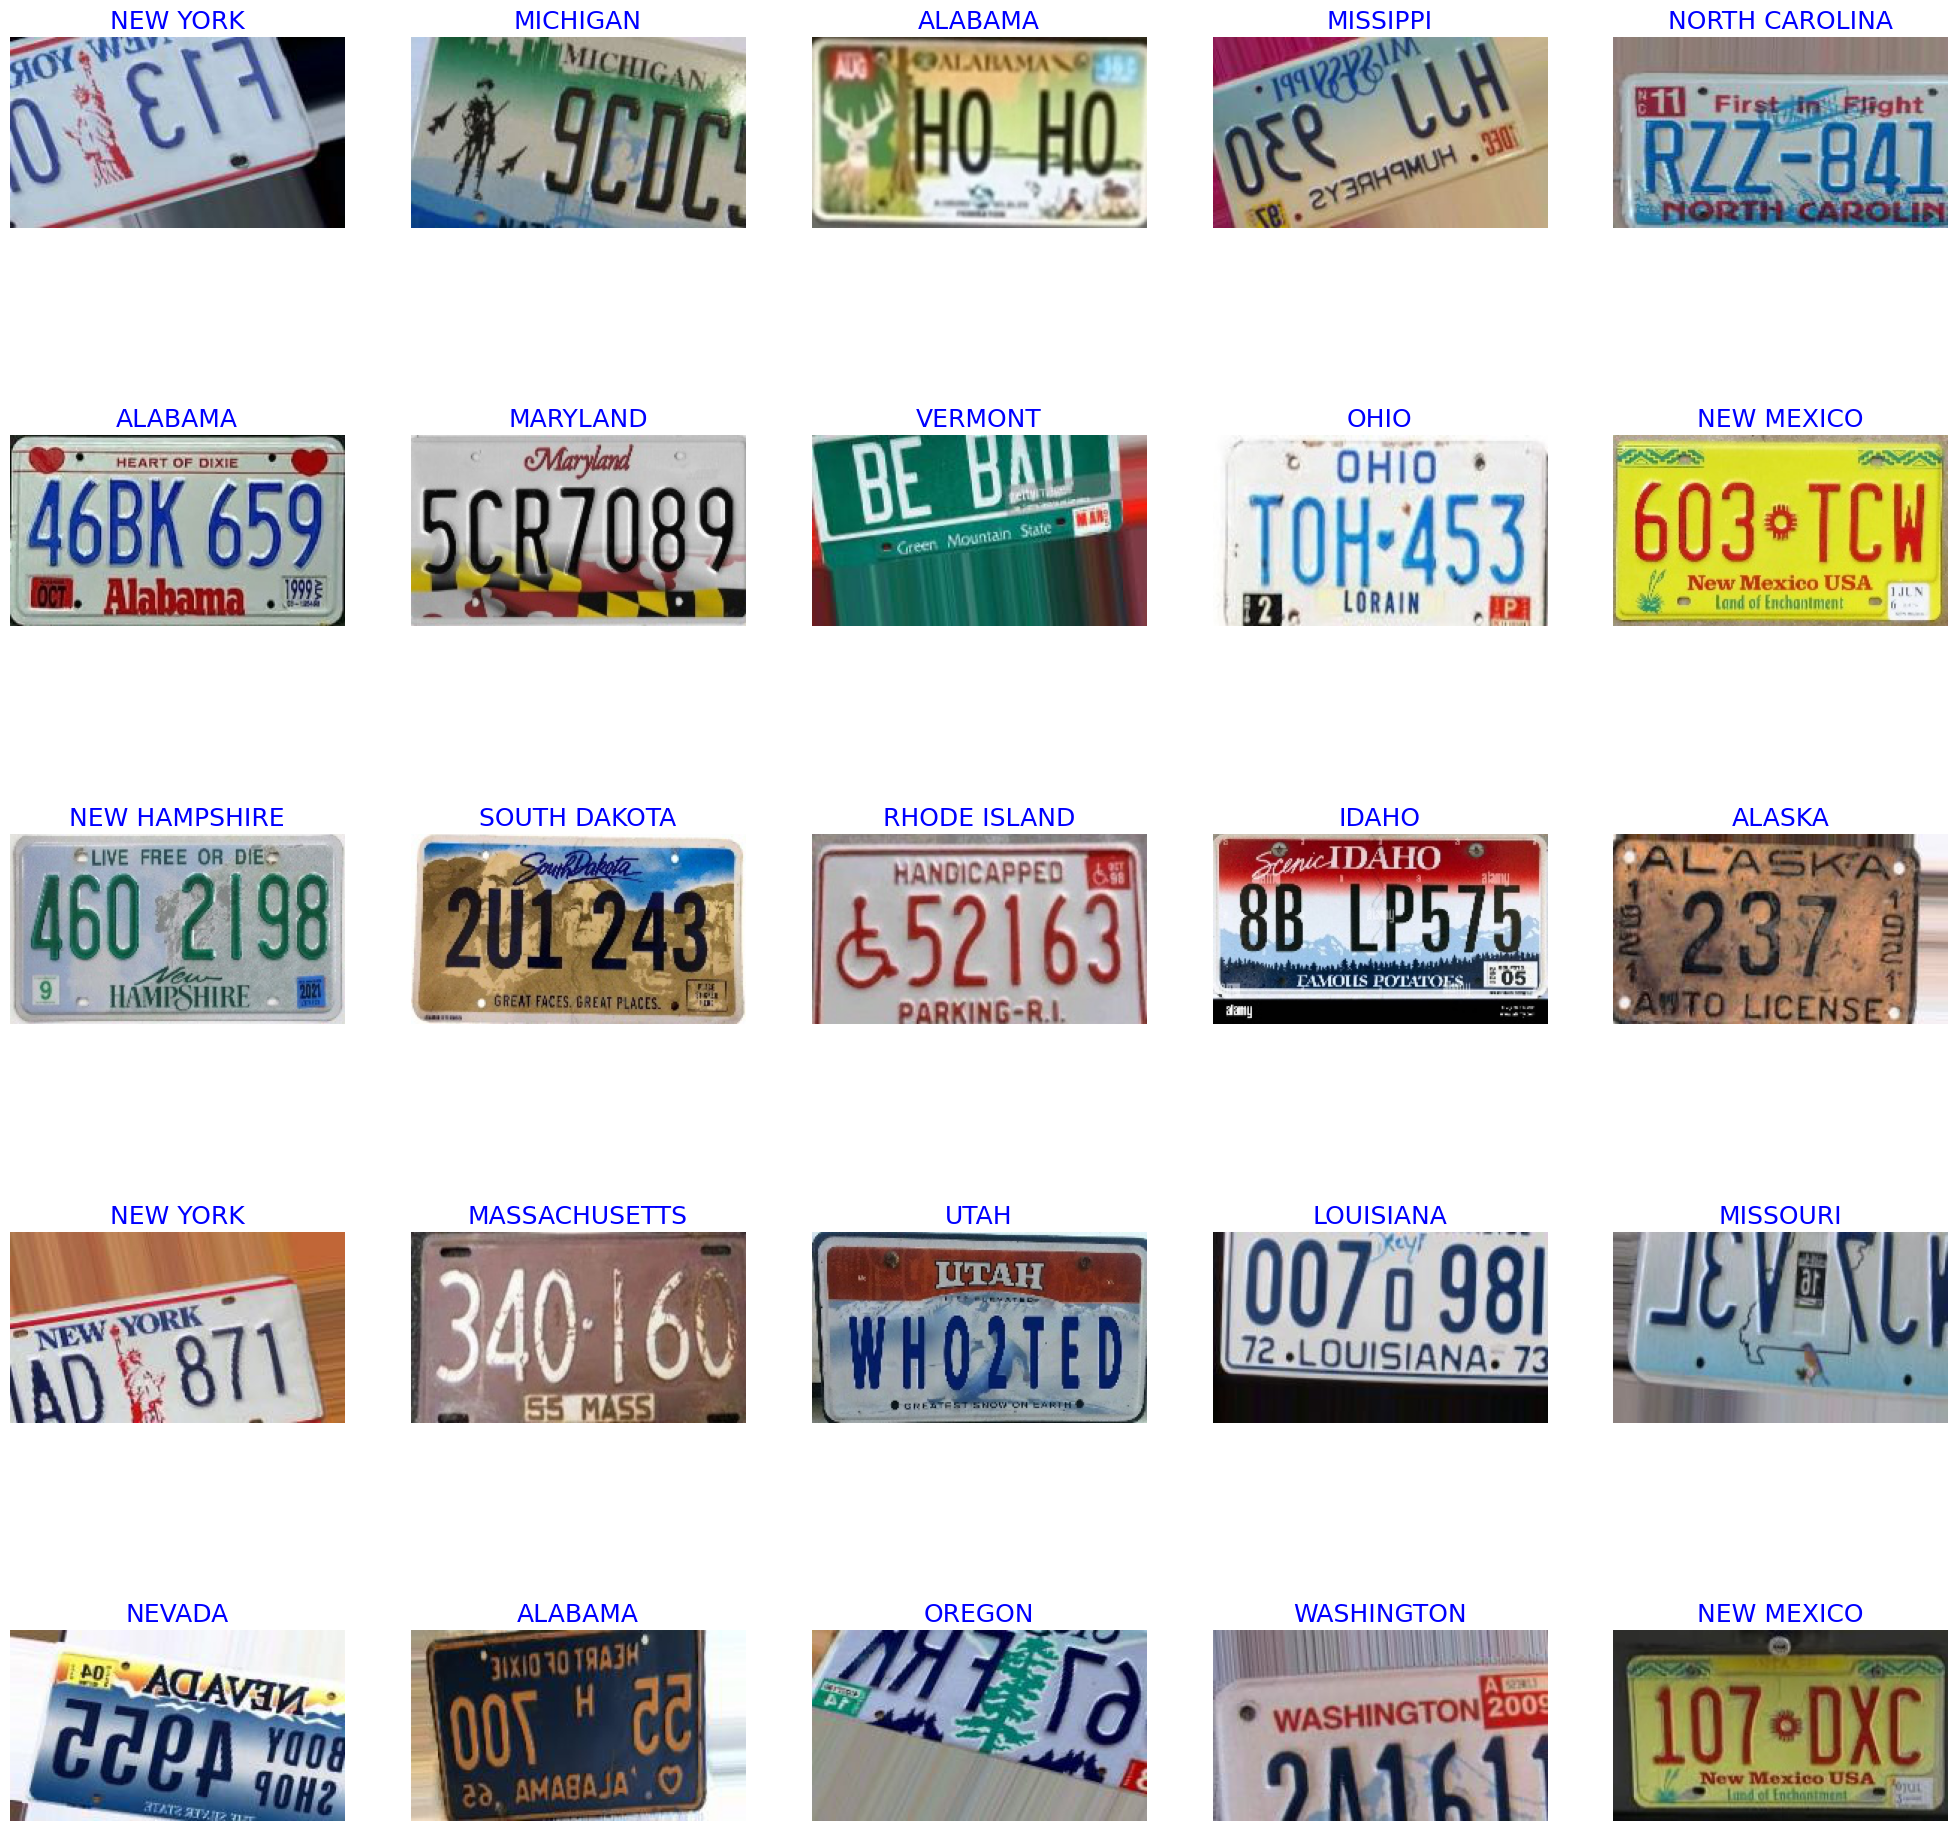

In [ ]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())
    images,labels=next(gen) # get a sample batch from the generator
    plt.figure(figsize=(25, 25))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i] /255
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=18)
        plt.axis('off')
    plt.show()

show_image_samples(train_gen )

### Creating a model using transfer learning with EfficienttNetB3?

In [ ]:
def make_model(img_size, lr, mod_num=3):
    img_shape = (img_size[0], img_size[1],3)
    base_model = tf.keras.applications.efficientnet.EfficientNetB3(
        include_top=False, weights='imagenet', input_shape=img_shape, pooling='max')

    msg = 'Created EfficientNet B3 model'
    base_model.trainable = True
    x = base_model.output
    x = layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
    x = layers.Dense(256, kernel_regularizer=regularizers.l2(l=0.016), activity_regularizer=regularizers.l1(
        0.006), bias_regularizer=regularizers.l1(0.006), activation='relu')(x)
    x = layers.Dropout(rate=0.4, seed=123)(x)
    output = layers.Dense(class_count, activation = 'softmax')(x)
    model = models.Model(inputs = base_model.input, outputs=output)
    model.compile(Adamax(learning_rate=lr), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    msg = msg + f'with initial learning rate set to {lr}'
    print(msg)
    return model

lr = 0.001
model = make_model(img_size, lr)


Created EfficientNet B3 modelwith initial learning rate set to 0.001


In [ ]:
class LR_ASK(keras.callbacks.Callback):
    def __init__(self, model, epochs, ask_epoch, dwell=True, factor=0.4):
        super(LR_ASK, self).__init__()
        self.model = model
        self.ask_epoch = ask_epoch
        self.epochs = epochs
        self.ask =True
        self.lowest_vloss = np.inf
        self.lowest_aloss = np.inf
        self.best_weights = self.model.get_weights()
        self.best_epoch = 1
        self.plist = []
        self.alist = []
        self.dwell = dwell
        self.factor = factor

    def get_list(self):
        return self.plist, self.alist

    def on_train_begin(self, logs=None):
        if self.ask_epoch == 0:
            print_in_colour('you set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch = 1
        if self.ask_epoch >= self.epochs:
            print_in_colour('ask_epoch>= epochs, will train for',
                  epochs, ' epochs', flush=True)
            self.ask = False
        if self.epochs == 1:
            self.ask = False
        else:
            msg = f'Training will proceed until epoch {ask_epoch} then you will be asked to '
            print_in_colour(msg)
            msg = 'enter H to halt training or enter an integer for how many epochs to run then be asked again'
            print_in_colour(msg)
            if self.dwell:
                msg = 'learning rate will be automatically adjusted during training'
                print_in_colour(msg)
        self.start_time = time.time()

    def on_train_end(self, logs=None):
        msg = f'loading model with weights from epoch { self.best_epoch}'
        print_in_colour(msg)
        model.set_weights(self.best_weights)
        tf_duration = time.time() - self.start_time

        hours = tf_duration // 3600
        minutes = (tf_duration - (hours * 3600)) // 60
        seconds = tf_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds'
        print_in_colour(msg)

    def on_epoch_end(self, epoch, logs=None):
        vloss = logs.get('val_loss')
        aloss = logs.get('loss')

        if epoch > 0:
            deltav = self.lowest_vloss - vloss
            pimprov = (deltav/self.lowest_vloss) * 100
            self.plist.append(pimprov)
            deltaa = self.lowest_aloss - aloss
            aimprov = (deltaa/self.lowest_aloss) * 100
            self.alist.append(aimprov)
        else:
            pimprov = 0.0
            aimprov = 0.0
        if vloss < self.lowest_vloss:
            self.lowest_vloss = vloss
            self.best_weights = self.model.get_weights()
            self.best_epoch = epoch + 1
            msg = f'\n validation loss of {vloss:7.4f} is {pimprov: 7.4f} % blow lowest loss, saving weights from epoch {str(epoch + 1) :3s} as best weights'
            print_in_colour(msg)
        else:
            pimprov = abs(pimprov)
            msg = f'\n validation loss of {vloss:7.4f} is {pimprov:7.4f} % above lowest loss of {self.lowest_vloss:7.4f} keeping weights from epoch {str(self.best_epoch)} as best weights'
            print_in_colour(msg)
            if self.dwell:
                lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))
                new_lr = lr * self.factor
                msg = f'learning rate was automatically adjusted from {lr:8.6f} to {new_lr:8.6f}, model weights set to best weights'
                print_in_colour(msg)
                tf.keras.backend.set_value(self.model.optimizer.lr, new_lr)
                model.set_weights(self.best_weights)

        if aloss < self.lowest_aloss:
            self.lowest_aloss = aloss
        if self.ask:
            if epoch + 1 == self.ask_epoch:
                msg = '\n Enter H to end training or and integer for the number of additional epochs to run then ask again'
                print_in_colour(msg)
                ans = input()

                if ans == 'H' or ans == 'h' or ans == '0':
                    msg = f'you entered {ans}, Training halted on epochs {epoch+1} due to user input\n'
                    print_in_colour(msg)
                    self.model.stop_training = True
                else:
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.epochs:
                        print_in_colour('\nYou specified maximum epochs of as ', self.epochs,
                              ' cannot train for', self.ask_epoch, flush=True)
                    else:
                        msg = f'you entered {ans} Training will continue to epoch {self.ask_epoch}'
                        print_in_colour(msg)
                        if self.dwell == False:
                            lr = float(tf.keras.backend.get_value(
                                self.model.optimizer.lr))
                            msg = f'current LR is {lr:8.6f} hit enter to keep this LR or enter a new LR'
                            print_in_colour(msg)
                            ans = input(' ')
                            if ans == '':
                                msg = f'keeping current LR of {lr:7.5f}'
                                print_in_colour(msg)
                                new_lr = float(ans)
                                tf.keras.backend.set_value(
                                    self.model.optimiser.lr, new_lr)
                                msg = f'changing LR to {ans}'
                                print_in_colour(msg)


In [ ]:
epochs = 15
ask_epoch=5
ask=LR_ASK(model, epochs, ask_epoch)
callbacks=[ask]

In [ ]:
history = model.fit(x=train_gen, epochs=epochs, verbose=1, callbacks=callbacks,
                    validation_data=valid_gen, validation_steps=None, shuffle=False, initial_epoch=0)


Training will proceed until epoch 5 then you will be asked to 

enter H to halt training or enter an integer for how many epochs to run then be asked again

learning rate will be automatically adjusted during training

Epoch 1/15
391/391 [==============================] - ETA: 0s - loss: 8.5033 - accuracy: 0.3134
 validation loss of  5.3895 is  0.0000 % blow lowest loss, saving weights from epoch 1   as best weights

391/391 [==============================] - 3421s 9s/step - loss: 8.5033 - accuracy: 0.3134 - val_loss: 5.3895 - val_accuracy: 0.6880
Epoch 2/15
391/391 [==============================] - ETA: 0s - loss: 4.0478 - accuracy: 0.7187
 validation loss of  2.6211 is  51.3664 % blow lowest loss, saving weights from epoch 2   as best weights

391/391 [==============================] - 3505s 9s/step - loss: 4.0478 - accuracy: 0.7187 - val_loss: 2.6211 - val_accuracy: 0.8760
Epoch 3/15
391/391 [==============================] - ETA: 0s - loss: 2.0870 - accuracy: 0.8714
 validation lo

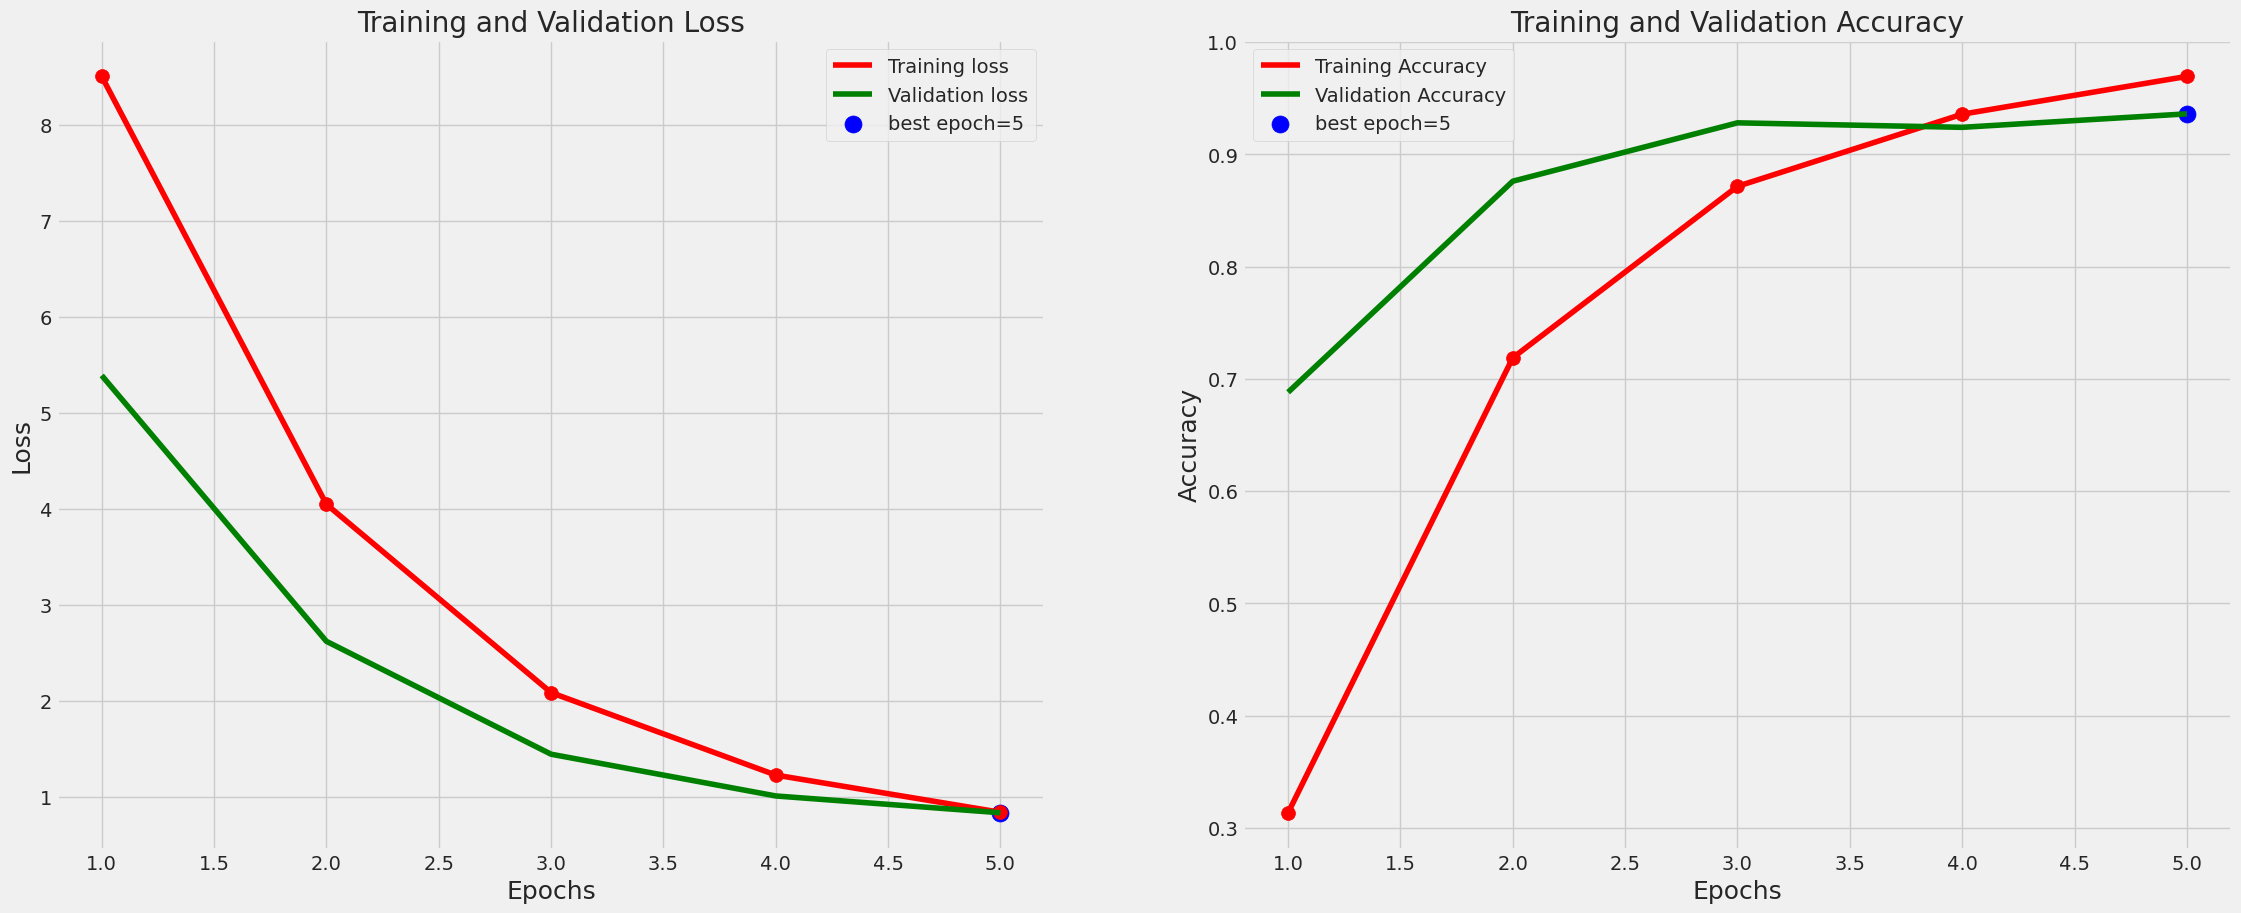

In [ ]:
def tr_plot(tr_data, start_epoch):
    tacc = tr_data.history['accuracy']
    tloss = tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc) + start_epoch
    Epochs=[]
    for i in range (start_epoch, Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch=' + str(index_loss+1+start_epoch)
    vc_label='best epoch=' + str(index_acc+1+start_epoch)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25,10))
    axes[0].plot(Epochs, tloss, 'r', label='Training loss')
    axes[0].plot(Epochs, vloss, 'g', label='Validation loss')
    axes[0].scatter(index_loss+1+start_epoch, val_lowest, s=150, c='blue', label=sc_label)
    axes[0].scatter(Epochs,tloss, s=100, c='red')
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs', fontsize=18)
    axes[0].set_ylabel('Loss', fontsize=18)
    axes[0].legend()
    axes[1].plot(Epochs, tacc, 'r', label='Training Accuracy')
    axes[1].scatter(Epochs, tacc, s=100, c='red')
    axes[1].plot(Epochs, vacc, 'g', label='Validation Accuracy')
    axes[1].scatter(index_acc+1+start_epoch, acc_highest, s=150, c='blue', label=vc_label)
    axes[1].set_title("Training and Validation Accuracy")
    axes[1].set_xlabel('Epochs', fontsize=18)
    axes[1].set_ylabel('Accuracy', fontsize=18)
    axes[1].legend()
    plt.show()
    return index_loss

loss_index = tr_plot(history, 0)

In [ ]:
def predictor(test_gen):
    y_pred=[]
    error_list=[]
    y_true=test_gen.labels
    classes=list(test_gen.class_indices.keys())
    class_count=len(classes)
    errors=0
    preds=model.predict(test_gen, verbose=1)
    tests=len(preds)

    for i, p in enumerate(preds):
        file=test_gen.filenames[i]
        pred_index=np.argmax(p)
        ture_index=test_gen.labels[i]
        if pred_index != ture_index:
            errors=errors + 1
            file=test_gen.filenames[i]
            error_class=classes[pred_index]
            t=(file, error_class)
            error_list.append(t)
        y_pred.append(pred_index)

    acc=(1-errors/tests) * 100
    msg=f'there were {errors} errors in {tests} tests for and accuracy of {acc:6.2f}'
    print_in_colour(msg, (0,255,255), (100, 100, 100))
    ypred = np.array(y_pred)
    ytrue=np.array(y_true)
    f1score=f1_score(ytrue, ypred, average='weighted') * 100
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred)
        plt.figure(figsize=(12,8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(class_count)+0.5, classes, rotation=90)
        plt.yticks(np.arrange(class_count)+0.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes, digits=4)

    print("Classification REport:\n-------------------------\n", clr)
    return errors, tests, error_list, f1score

errors, tests, error_list, f1score=predictor(test_gen)

8/8 [==============================] - 3s 334ms/step
there were 9 errors in 250 tests for and accuracy of  96.40

Classification REport:
-------------------------
                 precision    recall  f1-score   support

       ALABAMA     1.0000    1.0000    1.0000         5
        ALASKA     1.0000    1.0000    1.0000         5
       ARIZONA     1.0000    1.0000    1.0000         5
      ARKANSAS     1.0000    1.0000    1.0000         5
    CALIFORNIA     1.0000    1.0000    1.0000         5
      COLORADO     1.0000    1.0000    1.0000         5
   CONNECTICUT     1.0000    1.0000    1.0000         5
      DELAWARE     0.8000    0.8000    0.8000         5
       FLORIDA     1.0000    1.0000    1.0000         5
       GEORGIA     1.0000    1.0000    1.0000         5
         HAWAI     1.0000    1.0000    1.0000         5
         IDAHO     1.0000    1.0000    1.0000         5
      ILLINOIS     0.8333    1.0000    0.9091         5
       INDIANA     1.0000    1.0000    1.0000      

In [ ]:
if len(error_list) > 0 and len(error_list)< 100:
    print('Below is a list of test files that were miss classified \n')
    print('{0:^30s}{1:^30s}'.format('Test File', 'Predicted as'))
    sorted_list = sorted(error_list)
    for i in range(len(sorted_list)):
        fpath=sorted_list[i][0]
        split=fpath.split('/')
        f=split[4] + split[5]
        pred_class=sorted_list[i][1]
        print(f'{f:^30s}{pred_class:^30s}')

Below is a list of test files that were miss classified 

          Test File                    Predicted as         
          platestest                     ILLINOIS           
          platestest                   PENNSYLVANIA         
          platestest                   PENNSYLVANIA         
          platestest                     DELAWARE           
          platestest                       OHIO             
          platestest                   NORTH DAKOTA         
          platestest                  SOUTH CAROLINA        
          platestest                   NORTH DAKOTA         
          platestest                   NORTH DAKOTA         


### Save the model

In [ ]:
name = 'pates-' + str(len(classes)) + '-(' + str(img_size[0]) + ' X ' + str(img_size[1]) + ')'
save_id = f'{name} -{f1score:5.2}.h5'
try:
    model_save_loc=os.path.join(working_dir, save_id)
    model.save(model_save_loc)
    msg=f'model was save as {model_save_loc}'
    print_in_colour(msg, (0,255,255))
except:
    msg1='Kaggle recently  modified its docker file to load tensflow version 2.11.0.\n '
    msg2=' Tensorflow versions 2.10.0  or higher have a bug that prevents saving of \n'
    msg3='EfficientNet models. If you want to save your model put the code below \n'
    msg4=' at the very start of your notebook. It installs tensorflow 2.9 which works \n'
    msg5= '! pip install tensorflow == 2.9.'
    msg=msg1 +msg2 +msg3 + msg4 + msg5
    print (msg)

Kaggle recently  modified its docker file to load tensflow version 2.11.0.
  Tensorflow versions 2.10.0  or higher have a bug that prevents saving of 
EfficientNet models. If you want to save your model put the code below 
 at the very start of your notebook. It installs tensorflow 2.9 which works 
! pip install tensorflow == 2.9.
